In [78]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sbn
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn import svm
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import roc_auc_score, average_precision_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.linear_model import LogisticRegression
import importlib as imp

In [2]:
raw = pd.read_csv('./wine+quality/winequality-red.csv', sep=';')
RANDOM_STATE = 0 # random_state
NUMBER_OF_FOLDS = 5
randomizer = np.random.RandomState(RANDOM_STATE)
column_names = list(raw.columns)
feature_names = column_names[:-1]
target_name = column_names[-1]
train_examples, test_examples = train_test_split(np.asarray(raw[feature_names]), test_size=0.2, random_state=RANDOM_STATE)
train_labels, test_labels = train_test_split(np.asarray(raw[target_name]), test_size=0.2, random_state=RANDOM_STATE)
# randomizer.shuffle(train_examples)
# randomizer.shuffle(test_examples)
# randomizer.shuffle(train_labels)
# randomizer.shuffle(test_labels)
print(f"train examples: {train_examples.shape}")
print(f"test examples:  {test_examples.shape}")
print(f"train labels:   {train_labels.shape}")
print(f"test labels:    {test_labels.shape}")
# """prepare for Stratified K-Fold cross validation"""
# imp.reload(baseline)
# splitter = StratifiedKFold(n_splits=NUMBER_OF_FOLDS)
# SKF_train_indices : list[NDArray] = []
# SKF_valid_indices : list[NDArray] = []
# for train, test in splitter.split(X=train_examples, y=train_labels):
#     SKF_train_indices.append(train)
#     SKF_valid_indices.append(test)

train examples: (1279, 11)
test examples:  (320, 11)
train labels:   (1279,)
test labels:    (320,)


In [112]:
def printer_best_params(found : GridSearchCV):
    print(f"best score: {found.best_score_}")
    # print(f"\tfrom: {found.cv_results_}")
    print(f"parameters:")
    for name in found.best_params_.keys():
        print(f"\t{name.replace('model__', '')}: {found.best_params_[name]}")
@ignore_warnings(category=ConvergenceWarning)
def grid_search_best_params(classifier, parameter_space, train_examples, train_labels,
    feature_scaling=True):
    if feature_scaling:
        pipe = Pipeline(steps=[
            ('scaler', StandardScaler()),
            ('model', classifier),
            ])
    else:
        pipe = Pipeline(steps=[
            ('model', classifier),
            ])
    search = GridSearchCV(estimator=pipe, param_grid=parameter_space, cv=StratifiedKFold(n_splits=NUMBER_OF_FOLDS).split(X=train_examples, y=train_labels),
        scoring='accuracy', verbose=10)
    search.fit(X=train_examples, y=train_labels)
    return search
@ignore_warnings(category=ConvergenceWarning)
def baseline(classifier, train_examples, train_labels, feature_scaling=True):
    if feature_scaling:
        pipe = Pipeline(steps=[
            ('scaler', StandardScaler()),
            ('model', classifier),
            ])
    else:
        pipe = Pipeline(steps=[
            ('model', classifier),
            ])
    scores = cross_validate(estimator=pipe, X=train_examples, y=train_labels, cv=StratifiedKFold(n_splits=NUMBER_OF_FOLDS).split(X=train_examples, y=train_labels),
        scoring='accuracy')
    aggregate = np.mean(scores['test_score'])
    print(f"Baseline performance: {aggregate}")
    return aggregate
def evaluate(model, test_examples, test_labels):
    print(f'test accuracy: {model.score(test_examples, test_labels)}')
    score = model.predict_proba(test_examples)
    print(f'test ROC AUC: {roc_auc_score(y_true=test_labels, y_score=score, multi_class="ovr")}')
    print(f'test Average Precision: {average_precision_score(y_true=test_labels, y_score=score, average="weighted")}')
    prediction = model.predict(test_examples)
    print(f'test confusion matrix')
    print(confusion_matrix(y_true=test_labels, y_pred=prediction))
    print(f'test classification report:')
    print(classification_report(y_true=test_labels, y_pred=prediction, zero_division=0.0))

In [113]:
"""SVC baseline"""
svc_base = baseline(classifier=svm.SVC(probability=True, random_state=RANDOM_STATE),
    train_examples=train_examples,
    train_labels=train_labels)

Baseline performance: 0.6004656862745098


In [34]:
"""SVC"""
svc_parameter_space = {
        # 'model__C': [1],
        'model__C': [0.001, 0.01, 0.1, 1, 10, 100],
        'model__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'model__degree': [3, 4, 5, 6]
        }
svc_found = grid_search_best_params(
    classifier=svm.SVC(probability=True, random_state=RANDOM_STATE),
    parameter_space=svc_parameter_space,
    train_examples=train_examples,
    train_labels=train_labels)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
[CV 1/5; 1/96] START model__C=0.001, model__degree=3, model__kernel=linear......
[CV 1/5; 1/96] END model__C=0.001, model__degree=3, model__kernel=linear;, score=0.516 total time=   0.1s
[CV 2/5; 1/96] START model__C=0.001, model__degree=3, model__kernel=linear......
[CV 2/5; 1/96] END model__C=0.001, model__degree=3, model__kernel=linear;, score=0.492 total time=   0.1s
[CV 3/5; 1/96] START model__C=0.001, model__degree=3, model__kernel=linear......
[CV 3/5; 1/96] END model__C=0.001, model__degree=3, model__kernel=linear;, score=0.512 total time=   0.1s
[CV 4/5; 1/96] START model__C=0.001, model__degree=3, model__kernel=linear......
[CV 4/5; 1/96] END model__C=0.001, model__degree=3, model__kernel=linear;, score=0.484 total time=   0.1s
[CV 5/5; 1/96] START model__C=0.001, model__degree=3, model__kernel=linear......
[CV 5/5; 1/96] END model__C=0.001, model__degree=3, model__kernel=linear;, score=0.502 total time=   0.1s
[CV

best score: 0.60828125
parameters:
	C: 10
	degree: 3
	kernel: rbf
test accuracy: 0.659375
test ROC AUC: 0.8411465161574254
test Average Precision: 0.6848172453592796
test confusion matrix
[[  0   0   1   1   0   0]
 [  0   0   7   4   0   0]
 [  0   2 107  24   2   0]
 [  0   1  37  88  16   0]
 [  0   0   2   9  16   0]
 [  0   0   0   1   2   0]]
test classification report:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00        11
           5       0.69      0.79      0.74       135
           6       0.69      0.62      0.65       142
           7       0.44      0.59      0.51        27
           8       0.00      0.00      0.00         3

    accuracy                           0.66       320
   macro avg       0.31      0.33      0.32       320
weighted avg       0.64      0.66      0.65       320

show confusion matrix as graph


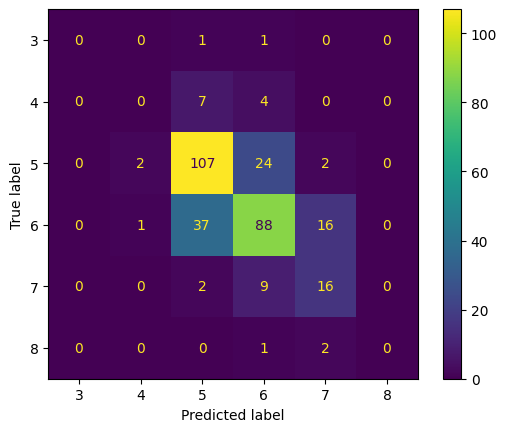

In [86]:
printer_best_params(svc_found)
evaluate(svc_found.best_estimator_, test_examples, test_labels)
print(f"show confusion matrix as graph")
ConfusionMatrixDisplay.from_estimator(svc_found.best_estimator_, test_examples, test_labels)

In [115]:
"""MLP baseline"""
mlp_base = baseline(classifier=MLPClassifier(max_iter=1000, random_state=RANDOM_STATE),
    train_examples=train_examples,
    train_labels=train_labels)

Baseline performance: 0.6059283088235294


In [68]:
mlp_parameter_space = {
        'model__learning_rate_init': [1e-4, 1e-3, 1e-2, 1e-1],
        'model__alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1],
        'model__activation': ['logistic', 'tanh', 'relu'],
        'model__solver': ['sgd', 'adam']
        }
mlp_found = grid_search_best_params(
    classifier=MLPClassifier(max_iter=1000, random_state=RANDOM_STATE),
    parameter_space=mlp_parameter_space,
    train_examples=train_examples,
    train_labels=train_labels)

Fitting 5 folds for each of 120 candidates, totalling 600 fits
[CV 1/5; 1/120] START model__activation=logistic, model__alpha=0.0001, model__learning_rate_init=0.0001, model__solver=sgd
[CV 1/5; 1/120] END model__activation=logistic, model__alpha=0.0001, model__learning_rate_init=0.0001, model__solver=sgd;, score=0.480 total time=   0.9s
[CV 2/5; 1/120] START model__activation=logistic, model__alpha=0.0001, model__learning_rate_init=0.0001, model__solver=sgd
[CV 2/5; 1/120] END model__activation=logistic, model__alpha=0.0001, model__learning_rate_init=0.0001, model__solver=sgd;, score=0.473 total time=   1.0s
[CV 3/5; 1/120] START model__activation=logistic, model__alpha=0.0001, model__learning_rate_init=0.0001, model__solver=sgd
[CV 3/5; 1/120] END model__activation=logistic, model__alpha=0.0001, model__learning_rate_init=0.0001, model__solver=sgd;, score=0.473 total time=   1.0s
[CV 4/5; 1/120] START model__activation=logistic, model__alpha=0.0001, model__learning_rate_init=0.0001, m

best score: 0.619234068627451
parameters:
	activation: relu
	alpha: 0.1
	learning_rate_init: 0.01
	solver: sgd
test accuracy: 0.63125
test ROC AUC: 0.7569238794057123
test Average Precision: 0.6570663116506162
test confusion matrix
[[ 0  0  2  0  0  0]
 [ 0  0  7  3  1  0]
 [ 0  1 99 32  3  0]
 [ 0  1 35 89 17  0]
 [ 0  0  2 11 14  0]
 [ 0  0  0  1  2  0]]
test classification report:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00        11
           5       0.68      0.73      0.71       135
           6       0.65      0.63      0.64       142
           7       0.38      0.52      0.44        27
           8       0.00      0.00      0.00         3

    accuracy                           0.63       320
   macro avg       0.29      0.31      0.30       320
weighted avg       0.61      0.63      0.62       320

show confusion matrix as graph


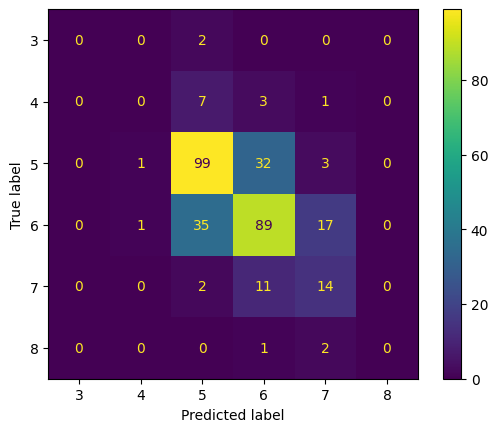

In [85]:
printer_best_params(mlp_found)
evaluate(mlp_found.best_estimator_, test_examples, test_labels)
print(f"show confusion matrix as graph")
ConfusionMatrixDisplay.from_estimator(mlp_found.best_estimator_, test_examples, test_labels)

In [116]:
"""RF baseline"""
rf_base = baseline(
    classifier=RandomForestClassifier(random_state=RANDOM_STATE),
    train_examples=train_examples,
    train_labels=train_labels)

Baseline performance: 0.6520833333333333


In [71]:
rf_parameter_space = {
        'model__n_estimators': [25, 50, 100, 150, 200],
        'model__criterion': ['gini', 'entropy', 'log_loss'],
        'model__max_features': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
        }
rf_found = grid_search_best_params(
    classifier=RandomForestClassifier(random_state=RANDOM_STATE),
    parameter_space=rf_parameter_space,
    train_examples=train_examples,
    train_labels=train_labels)

Fitting 5 folds for each of 165 candidates, totalling 825 fits
[CV 1/5; 1/165] START model__criterion=gini, model__max_features=1, model__n_estimators=25
[CV 1/5; 1/165] END model__criterion=gini, model__max_features=1, model__n_estimators=25;, score=0.625 total time=   0.0s
[CV 2/5; 1/165] START model__criterion=gini, model__max_features=1, model__n_estimators=25
[CV 2/5; 1/165] END model__criterion=gini, model__max_features=1, model__n_estimators=25;, score=0.660 total time=   0.0s
[CV 3/5; 1/165] START model__criterion=gini, model__max_features=1, model__n_estimators=25
[CV 3/5; 1/165] END model__criterion=gini, model__max_features=1, model__n_estimators=25;, score=0.664 total time=   0.0s
[CV 4/5; 1/165] START model__criterion=gini, model__max_features=1, model__n_estimators=25
[CV 4/5; 1/165] END model__criterion=gini, model__max_features=1, model__n_estimators=25;, score=0.660 total time=   0.0s
[CV 5/5; 1/165] START model__criterion=gini, model__max_features=1, model__n_estimato

best score: 0.6724172794117648
parameters:
	criterion: gini
	max_features: 1
	n_estimators: 100
test accuracy: 0.709375
test ROC AUC: 0.7876924000511677
test Average Precision: 0.782000074325853
test confusion matrix
[[  0   0   0   2   0   0]
 [  0   0   7   4   0   0]
 [  0   0 109  24   2   0]
 [  0   0  28 106   8   0]
 [  0   0   1  12  12   2]
 [  0   0   0   1   2   0]]
test classification report:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00        11
           5       0.75      0.81      0.78       135
           6       0.71      0.75      0.73       142
           7       0.50      0.44      0.47        27
           8       0.00      0.00      0.00         3

    accuracy                           0.71       320
   macro avg       0.33      0.33      0.33       320
weighted avg       0.68      0.71      0.69       320

show confusion matrix as graph


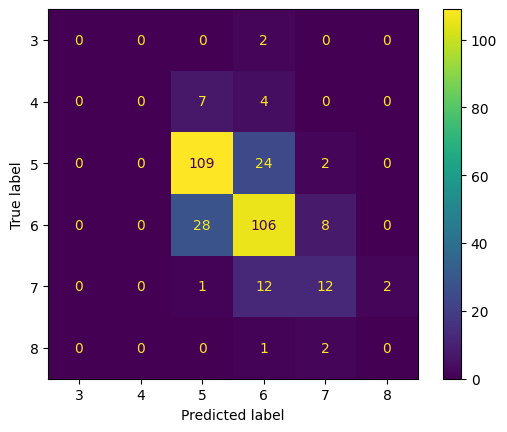

In [84]:
printer_best_params(rf_found)
evaluate(rf_found.best_estimator_, test_examples, test_labels)
print(f"show confusion matrix as graph")
ConfusionMatrixDisplay.from_estimator(rf_found.best_estimator_, test_examples, test_labels)

In [117]:
"""RF baseline, no feature scaling"""
rf_no_scale_base = baseline(
    classifier=RandomForestClassifier(random_state=RANDOM_STATE),
    train_examples=train_examples,
    train_labels=train_labels, feature_scaling=False)

Baseline performance: 0.6559957107843137


In [74]:
"""Random Forest, no feature scaling"""
rf_no_scale_found = grid_search_best_params(
    classifier=RandomForestClassifier(random_state=RANDOM_STATE),
    parameter_space=rf_parameter_space,
    train_examples=train_examples,
    train_labels=train_labels, feature_scaling=False)

Fitting 5 folds for each of 165 candidates, totalling 825 fits
[CV 1/5; 1/165] START model__criterion=gini, model__max_features=1, model__n_estimators=25
[CV 1/5; 1/165] END model__criterion=gini, model__max_features=1, model__n_estimators=25;, score=0.613 total time=   0.0s
[CV 2/5; 1/165] START model__criterion=gini, model__max_features=1, model__n_estimators=25
[CV 2/5; 1/165] END model__criterion=gini, model__max_features=1, model__n_estimators=25;, score=0.660 total time=   0.0s
[CV 3/5; 1/165] START model__criterion=gini, model__max_features=1, model__n_estimators=25
[CV 3/5; 1/165] END model__criterion=gini, model__max_features=1, model__n_estimators=25;, score=0.660 total time=   0.0s
[CV 4/5; 1/165] START model__criterion=gini, model__max_features=1, model__n_estimators=25
[CV 4/5; 1/165] END model__criterion=gini, model__max_features=1, model__n_estimators=25;, score=0.660 total time=   0.0s
[CV 5/5; 1/165] START model__criterion=gini, model__max_features=1, model__n_estimato

best score: 0.6747610294117647
parameters:
	criterion: gini
	max_features: 1
	n_estimators: 100
test accuracy: 0.709375
test ROC AUC: 0.7886603243097855
test Average Precision: 0.7818904343444878
test confusion matrix
[[  0   0   0   2   0   0]
 [  0   0   7   4   0   0]
 [  0   0 110  23   2   0]
 [  0   0  27 105  10   0]
 [  0   0   1  12  12   2]
 [  0   0   0   1   2   0]]
test classification report:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00        11
           5       0.76      0.81      0.79       135
           6       0.71      0.74      0.73       142
           7       0.46      0.44      0.45        27
           8       0.00      0.00      0.00         3

    accuracy                           0.71       320
   macro avg       0.32      0.33      0.33       320
weighted avg       0.68      0.71      0.69       320

show confusion matrix as graph


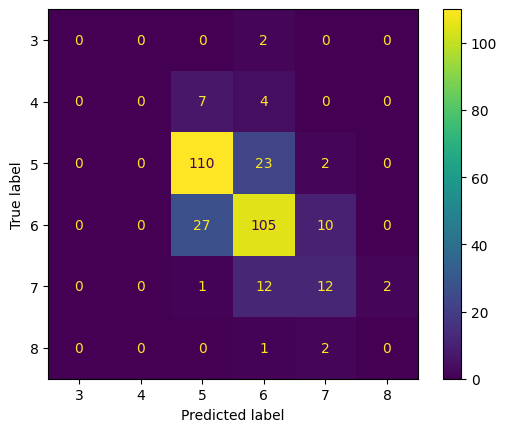

In [83]:
printer_best_params(rf_no_scale_found)
evaluate(rf_no_scale_found.best_estimator_, test_examples, test_labels)
print(f"show confusion matrix as graph")
ConfusionMatrixDisplay.from_estimator(rf_no_scale_found.best_estimator_, test_examples, test_labels)

In [118]:
"""Logistic Regression baseline"""
lr_base = baseline(
    classifier=LogisticRegression(random_state=RANDOM_STATE),
    train_examples=train_examples,
    train_labels=train_labels)

Baseline performance: 0.583265931372549


In [52]:
lr_parameter_space = {
        'model__C': [0.001, 0.01, 0.1, 1, 10, 100],
        'model__penalty': ['l1', 'l2', 'elasticnet'],
        'model__solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
        }
lr_found = grid_search_best_params(
    classifier=LogisticRegression(random_state=RANDOM_STATE),
    parameter_space=lr_parameter_space,
    train_examples=train_examples,
    train_labels=train_labels)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV 1/5; 1/108] START model__C=0.001, model__penalty=l1, model__solver=lbfgs....
[CV 1/5; 1/108] END model__C=0.001, model__penalty=l1, model__solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5; 1/108] START model__C=0.001, model__penalty=l1, model__solver=lbfgs....
[CV 2/5; 1/108] END model__C=0.001, model__penalty=l1, model__solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5; 1/108] START model__C=0.001, model__penalty=l1, model__solver=lbfgs....
[CV 3/5; 1/108] END model__C=0.001, model__penalty=l1, model__solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5; 1/108] START model__C=0.001, model__penalty=l1, model__solver=lbfgs....
[CV 4/5; 1/108] END model__C=0.001, model__penalty=l1, model__solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5; 1/108] START model__C=0.001, model__penalty=l1, model__solver=lbfgs....
[CV 5/5; 1/108] END model__C=0.001, model__penalty=l1, model__solver=lbfgs;, score=nan total time=   0.0s
[C

/Users/kronos.di.vlad/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
300 fits failed out of a total of 540.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/kronos.di.vlad/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/kronos.di.vlad/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/kronos.di.vlad/opt/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py", line 427, 

best score: 0.5856066176470588
parameters:
	C: 100
	penalty: l2
	solver: lbfgs
test accuracy: 0.634375
test ROC AUC: 0.7765271297935143
test Average Precision: 0.6111052142435649
test confusion matrix
[[  0   0   2   0   0   0]
 [  0   0   6   4   1   0]
 [  0   0 104  30   1   0]
 [  0   0  37  90  15   0]
 [  0   0   2  16   9   0]
 [  0   0   0   1   2   0]]
test classification report:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00        11
           5       0.69      0.77      0.73       135
           6       0.64      0.63      0.64       142
           7       0.32      0.33      0.33        27
           8       0.00      0.00      0.00         3

    accuracy                           0.63       320
   macro avg       0.27      0.29      0.28       320
weighted avg       0.60      0.63      0.62       320

show confusion matrix as graph


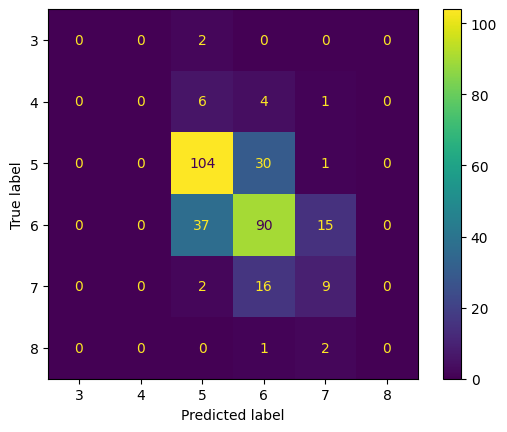

In [80]:
printer_best_params(lr_found)
evaluate(lr_found.best_estimator_, test_examples, test_labels)
print(f"show confusion matrix as graph")
ConfusionMatrixDisplay.from_estimator(lr_found.best_estimator_, test_examples, test_labels)

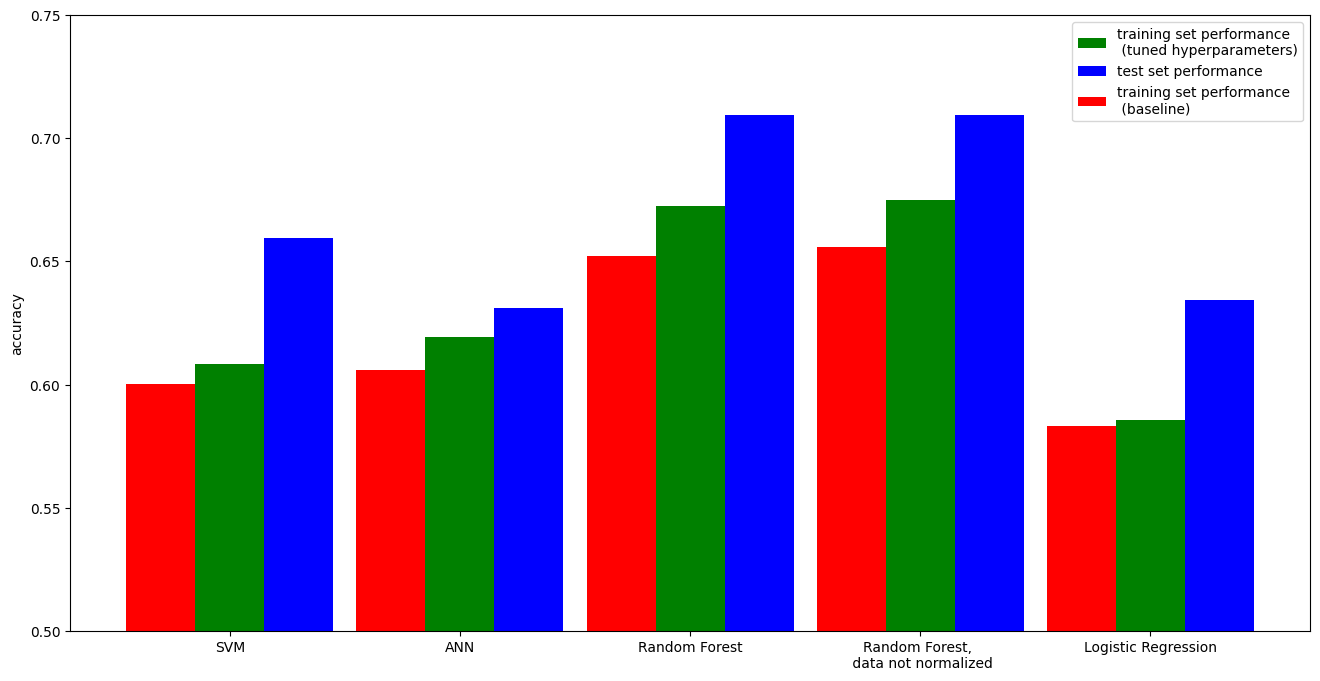

In [120]:
f, ax = plt.subplots(figsize=(16, 8))
bar_width = 0.3
ax.set_ylim(0.5, 0.75)
ax.set_ylabel('accuracy')
positions = np.asarray([1, 2, 3, 4, 5])
ax.bar(x = positions, height = [svc_found.best_score_, mlp_found.best_score_, rf_found.best_score_, 
    rf_no_scale_found.best_score_, lr_found.best_score_], 
    tick_label=['SVM', 'ANN', 'Random Forest', 'Random Forest, \n data not normalized', 'Logistic Regression'],
    color='green', width=bar_width, label='training set performance \n (tuned hyperparameters)')
ax.bar(x = positions + bar_width, height = [
    svc_found.score(test_examples, test_labels), 
    mlp_found.score(test_examples, test_labels), 
    rf_found.score(test_examples, test_labels), 
    rf_no_scale_found.score(test_examples, test_labels), lr_found.score(test_examples, test_labels)], 
    color='blue', width=bar_width, label='test set performance')
ax.bar(x = positions - bar_width, height = [
    svc_base, 
    mlp_base, 
    rf_base, 
    rf_no_scale_base, lr_base], 
    color='red', width=bar_width, label='training set performance \n (baseline)')
ax.legend()